<div align="center">
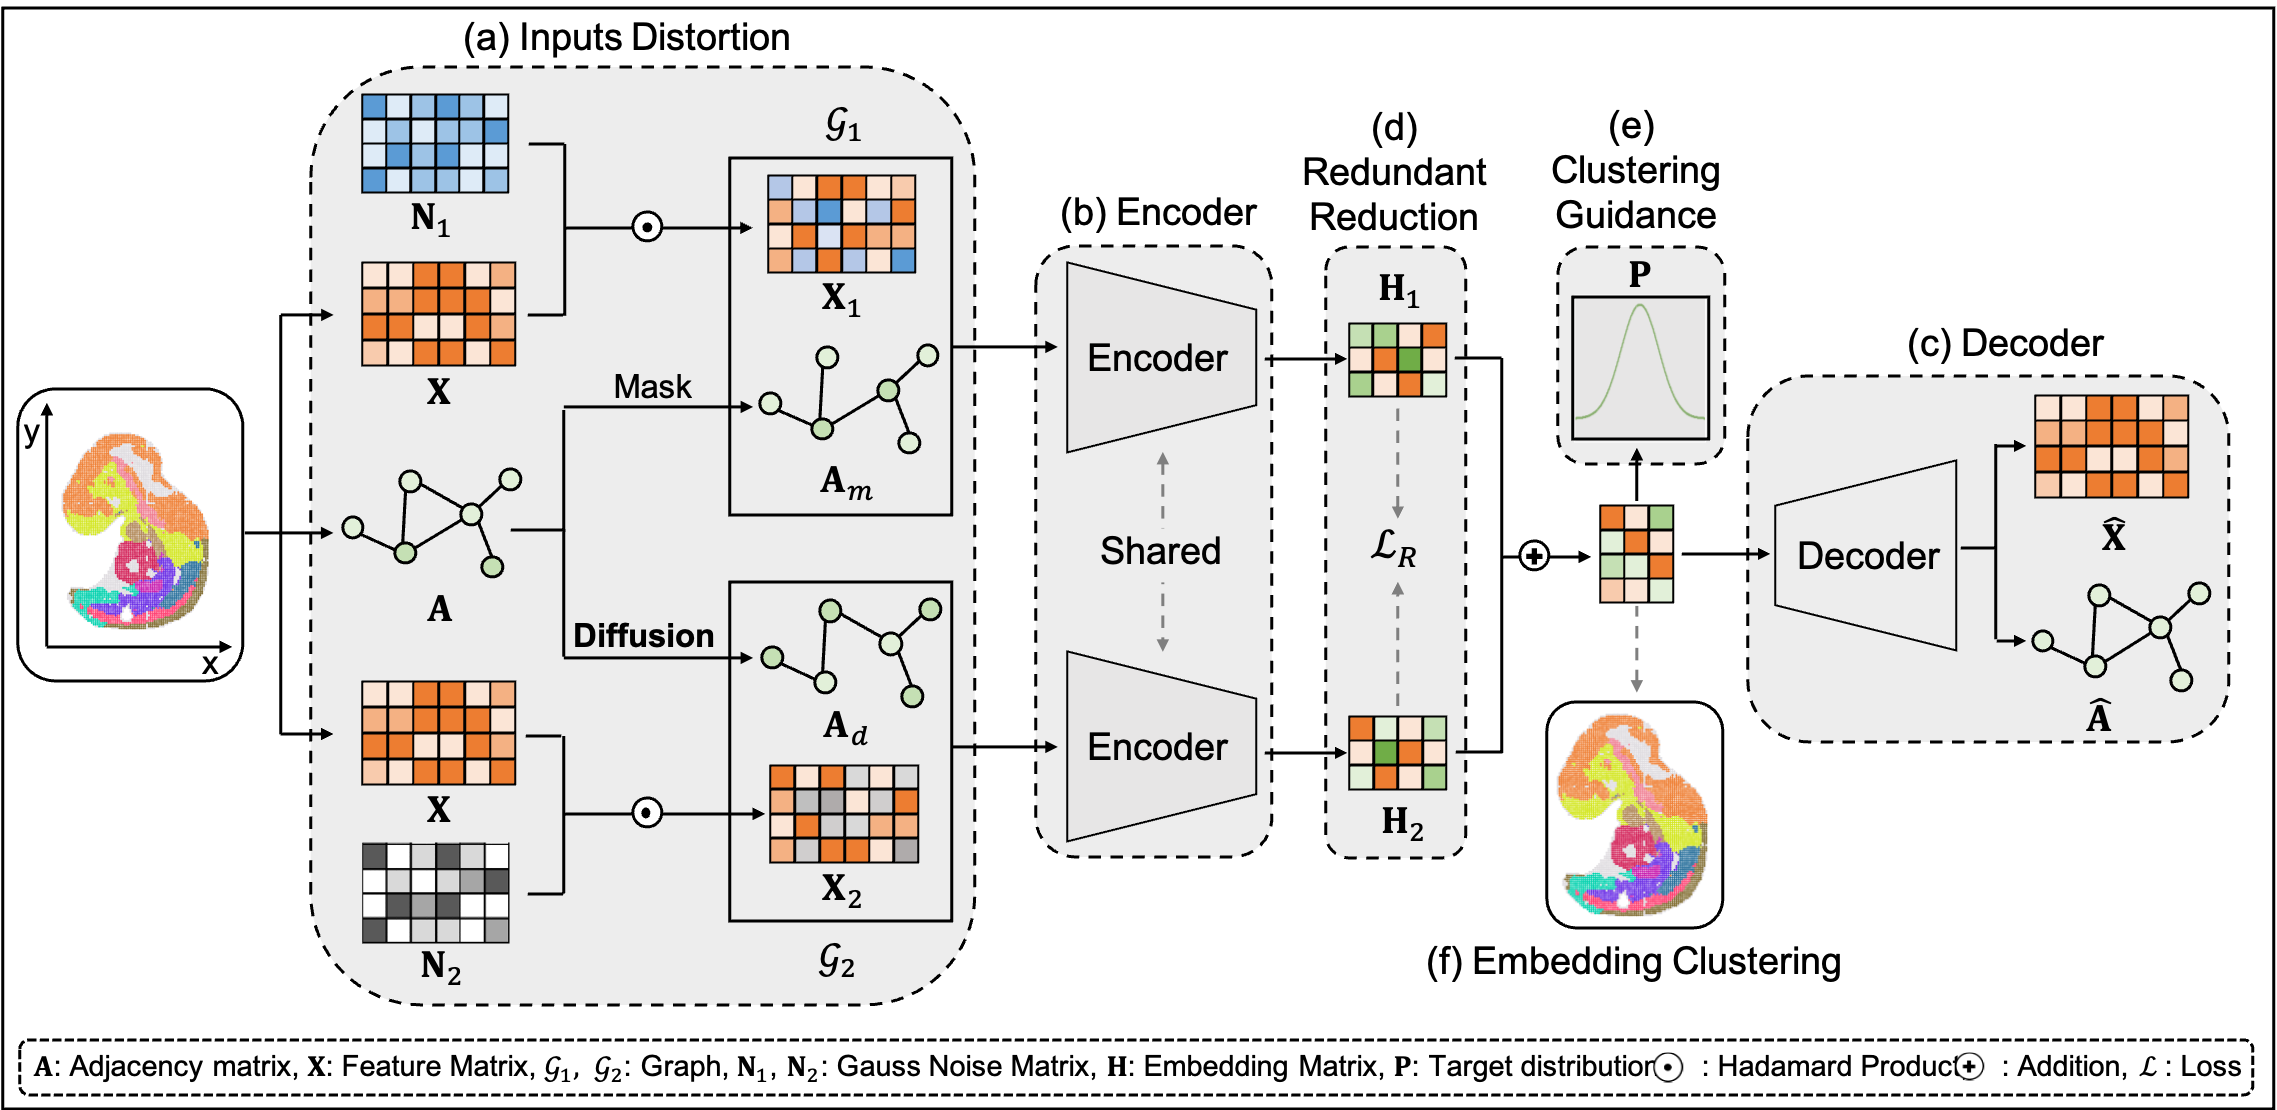
</div> 
<div align="center"><strong>Overview Of SGAE</strong>
</div>

# What is ***SGAE?***           
Spatial transcriptomics (ST) is a newly emerging field that facilitates a comprehensive characterization of tissue organization and architecture. By profiling the spatially-resolved gene expression patterns, ST technologies allow scientists to gain an in-depth understanding of the complex cellular dynamics and within tissue. Graph neural network (GNN) based methods usually suffer from representations collapse, which tends to map spatial spots into same representation. To address this issue, we proposed a Siamese Graph Autoencoder (SGAE) framework to learn discriminative spot representation and decipher accurate spatial domains. SGAE outperformed those spatial clustering methods across multiple platforms derived datasets based on the evaluation of ARI, FMI, NMI. Moreover, the clustering results derived from the SGAE model can be further utilized in 3D Drosophila Embryo reconstruction.


**Github:** https://github.com/STOmics/SGAE     
**Environment(Mirror):** sgae (URL: https://cloud.stomics.tech/#/public/image) 

# **Tutorial**            
In this tutorial, we demonstrate how to apply <strong>SGAE</strong> to identify spatial domains on datasets that were measured by different platforms. As an example, we analyse the mouse cortex sample.

# **Input and Output**                                    
>Input: Only `*.h5ad` is supported as an input file for the gene expression matrix. And the spatial position of the gene in the tissue section should be saved in `*.obsm['spatial']`.       
       
>Output: The clustering results will be saved in `*.obs['SGAE']`. You can choose Leiden, Louvain or mclust for spaital clustering.
        
# **Demo Data**   
|**Data**|**Spots/Cells**|**Genes**|**Platform**|**Donwload**|
|:----:|:----:|:----:|:----:|:----:|
|mouse cortex| 3106 | 254 | merfish | [https://doi.brainimagelibrary.org/](https://doi.brainimagelibrary.org/)|
          
    
# **Time Estimates**      
|**CPU Core**|**CPU Menory (G)**|**GPU Memory (G)**|**Running Time (min)**|
|:----:|:----:|:----:|:----:|
|32|~5|~10|~3|


# **Import Packages and Load Data**

In [1]:
from SGAE import SGAE

In [2]:
import gc
import os
import time
import scanpy as sc


from torch.utils.data import DataLoader

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import os.path as osp
from scanpy import read_h5ad
import torch
from SGAE.config import setup, set_path_models, print_setting
from SGAE.opt import args
from SGAE.utils import tensor_2_sparsetensor, preprocess, graph_construction_cluster, graph_construction_spatial_knn

In [3]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
# os.environ['R_HOME'] = '/scbio4/tools/R/R-4.0.3_openblas/R-4.0.3'

In [4]:
# the number of clusters
n_clusters = 22

In [5]:
dataset = 'mouse1sample1_left_top.h5ad'

In [6]:
# read data
adata = sc.read_h5ad(dataset)

In [7]:
adata

AnnData object with n_obs × n_vars = 3106 × 254
    obs: 'Unnamed: 0', 'sample_id', 'slice_id', 'class_label', 'subclass', 'label', 'X', 'Y', 'celltype', 'leiden', 'Kmeans'
    uns: 'Kmeans_colors', 'celltype_colors', 'leiden', 'leiden_colors', 'neighbors', 'subclass_colors'
    obsm: 'emb', 'spatial'
    obsp: 'connectivities', 'distances'

In [8]:
device

device(type='cuda', index=0)

In [9]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# **Training the Model**

In [10]:
args.name = dataset
args.n_clusters = n_clusters
setup(args)

adata, cm = preprocess(adata, args)

data_name:  mouse1sample1_left_top.h5ad setting:
error!
please add the new dataset's parameters
------------------------------
dataset       : 
device        : 
random seed   : 
clusters      : 
alpha value   : 
lambda value  : 
gamma value   : 
learning rate : 
------------------------------

------------------------------ preprocessed adata
AnnData object with n_obs × n_vars = 3106 × 254
    obs: 'Unnamed: 0', 'sample_id', 'slice_id', 'class_label', 'subclass', 'label', 'X', 'Y', 'celltype', 'leiden', 'Kmeans', 'n_genes'
    var: 'n_cells', 'mean', 'std'
    uns: 'Kmeans_colors', 'celltype_colors', 'leiden', 'leiden_colors', 'neighbors', 'subclass_colors', 'log1p'
    obsm: 'emb', 'spatial'
    obsp: 'connectivities', 'distances'

x.max: 11.2310505 x.min: -5.698046
 ARI 0.43 , FMI 0.49 , NMI 0.65 , ACC -1.00 , F1 -1.00
Louvain: 0.43117320529439324 0.48770455095329024 0.6502118185274496 -1 -1
 ARI 0.61 , FMI 0.65 , NMI 0.73 , ACC 0.70 , F1 0.62
Leiden: 0.43117320529439324 0.6475014784

In [11]:
from SGAE.utils import preprocess_graph

n_node = adata.shape[0]
cms = ['louvain', 'leiden', 'kmeans']
adj = graph_construction_cluster(adata.obs[cms[cm]].values.codes.reshape((n_node, 1)))
adj += graph_construction_spatial_knn(adata.obsm['spatial'], k_nn=args.k_nn)

graph_dict = preprocess_graph(adj, n_node, True, False)
graph_dict['adj_norm'] = tensor_2_sparsetensor(graph_dict['adj_norm'])
graph_dict['adj_ad'] = tensor_2_sparsetensor(graph_dict['adj_ad'])
graph_dict['adj_org'] = tensor_2_sparsetensor(graph_dict['adj_org'])

adj[0,0]: 2.0
degree.shape:  (3106,)
degree.shape:  (3106, 3106)
d_inv.shape:  (3106, 3106)


In [12]:
from SGAE.utils import LoadDataset
dataset = LoadDataset(adata.obsm['X_pca'])
data_X = torch.FloatTensor(dataset.x.copy())  # .cuda()
train_loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=args.shuffle)

args.modelname = 'SGAE_Nosym'
args.ae_modelname = 'ae'
args.gae_modelname = 'gae_Nosym'
args.pre_modelname = 'pre_Nosym'

In [13]:
from SGAE.train_HR import train_all_highRes
train_all_highRes(train_loader=train_loader, data=data_X, graph_dict=graph_dict, args=args, adata=adata)
gc.collect()
torch.cuda.empty_cache()

=================================== GAE ===================================


100%|██████████| 1000/1000 [21:34<00:00,  1.29s/it]
/opt/conda/lib/python3.8/site-packages/torch/distributed/distributed_c10d.py:262: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


Finish optimization.
gae训练时间： 1295.3315649032593
=================================== AE ===================================


100%|██████████| 1000/1000 [41:53<00:00,  2.51s/it]
/opt/conda/lib/python3.8/site-packages/torch/distributed/distributed_c10d.py:262: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


Finish optimization.
ae训练时间： 2513.366993665695
=================================== Pre ===================================


100%|██████████| 1000/1000 [12:00<00:00,  1.39it/s]
/opt/conda/lib/python3.8/site-packages/torch/distributed/distributed_c10d.py:262: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


Finish optimization.
pre训练时间： 720.7492060661316
pre训练完成时间： 4529.447764635086
=================================== SGAE ===================================
Training…
degree.shape:  (3106,)
degree.shape:  (3106, 3106)
d_inv.shape:  (3106, 3106)


  0%|          | 0/1000 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/torch/distributed/distributed_c10d.py:262: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(
100%|██████████| 1000/1000 [30:46<00:00,  1.85s/it] 


Finish optimization.
sgae训练时间： 1849.4460504055023
sgae训练完成时间： 6378.893815040588


# **Visualization**

In [14]:
from sklearn.metrics import normalized_mutual_info_score, fowlkes_mallows_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import preprocessing

preds = adata.obs['SGAE']
annotation = adata.obs['celltype']

le = preprocessing.LabelEncoder()
le.fit(annotation)
annotation = le.transform(annotation)

ari = adjusted_rand_score(annotation, preds)
nmi = normalized_mutual_info_score(annotation, preds, average_method='arithmetic')
fmi = fowlkes_mallows_score(annotation, preds)

print('Dataset:', dataset)
print('ARI:', ari)

Dataset: <SGAE.utils.LoadDataset object at 0x7f3a46cd6c70>
ARI: 0.4215512609937496


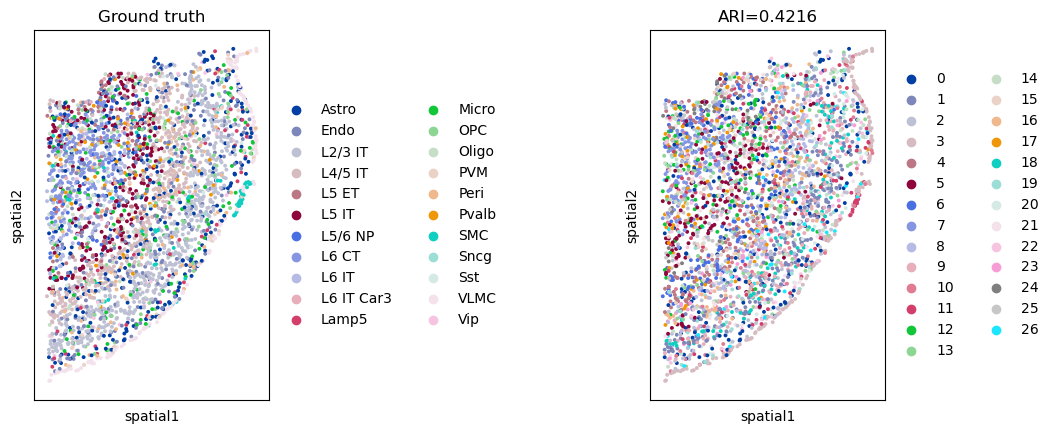

In [15]:
# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              color=["celltype", "SGAE"],
              title=["Ground truth", "ARI=%.4f"%ari],
              show=True, spot_size=30)

The visualization of clustering result(right panel) compared to the ground truth(left panel).

# **Contact Information**

For questions about this notebook, please contact: cloud@stomics.tech.

# **Cite**

If you use STOmics/Stereo-seq data in your research, please considering referring us in your article:

> **Code available**
The source code of this algorithm is available at Github (https://github.com/STOmics/SGAE). The visual and convenient execution of this algorithm can be found from STOmics Cloud Platform (https://cloud.stomics.tech/).

>**Acknowledgement**
We express our gratitude to the computing platform STOmics Cloud (https://cloud.stomics.tech/) for enabling workflow automation and accelerating Stereo-seq data analysis. If you use STOmics/Stereo-seq data in your research, please considering referring us in your article.


